In [ ]:
from typing import List,TypedDict
import re

import pypdf
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS

from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START,END
from pydantic import BaseModel
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
docs = (
    PyPDFLoader("../documents/book1.pdf").load()
    + PyPDFLoader("../documents/book2.pdf").load()
    + PyPDFLoader("../documents/book3.pdf").load()
)

## Chunking

In [5]:
chunks = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap = 150).split_documents(docs)

for d in chunks:
    d.page_content = d.page_content.encode("utf-8","ignore").decode("utf-8","ignore")

In [6]:
len(chunks)

12425

## Create Embeddings and Store in vectorDB

In [7]:
# embeddings = GoogleGenerativeAIEmbeddings(model="gemini-embedding-001")
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vector_store = FAISS.from_documents(chunks,embeddings)

e:\Machine Learning and Data Science\Advanced-RAGS\.venv\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Retriever

In [8]:
retriever = vector_store.as_retriever(search_type='similarity',search_kwargs={'k':1})

## Init LLM

In [9]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')

In [10]:
# llm = HuggingFaceEndpoint(
#     repo_id="mistralai/Mistral-7B-Instruct-v0.2",
#     task="text-generation"
# )

# llm = ChatHuggingFace(llm=llm)


# Graph Build

In [11]:
class State(TypedDict):

    question: str
    docs : List[Document]

    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    answer : str

### Retrieve Node

In [12]:
def retrieve(state: State):
    q = state['question']

    return {'docs': retriever.invoke(q)}

### Refine Node

In [ ]:
# Decomposition 

def decompose_to_sentence(text: str) -> List[str]:

    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]


# filter 
class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the questions\n"
            "Use only the sentence output json only"
        ),
        ("human", "Question: {question}\n\n Sentence: \n{sentence}")
    ]
)

filter_chain = filter_prompt | llm.with_structured_output(KeepOrDrop)


# Refining 
def refine(state: State):

    q = state['question']

    context = "\n\n".join([d.page_content for d in state['docs']]).strip()

    strips = decompose_to_sentence(context)

    kept : List[str] = []

    for s in strips:
        if filter_chain.invoke({"question":q,"sentence":s}).keep:
            kept.append(s)

    
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips":kept,
        "refined_context": refined_context,
    }


### Generate Node

In [14]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are Helpful ML tutor. Answer only using the provided refined bullets.\n"
            "If the bullets are empty or insufficient say: I don't Know based on the provided book"
        ),
        ("human","Question: {question}\n\nRefined Context \n {refined_context}")
    ]
)

def generate(state: State):

    out = (answer_prompt | llm).invoke({"question": state['question'],"refined_context": state['refined_context']})

    return {"answer": out.content}

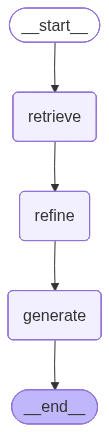

In [15]:
g = StateGraph(State)

g.add_node("retrieve",retrieve)
g.add_node("refine",refine)
g.add_node("generate",generate)

g.add_edge(START,"retrieve")
g.add_edge("retrieve","refine")
g.add_edge("refine","generate")
g.add_edge("generate",END)

app = g.compile()

app

In [16]:
res = app.invoke({"question":"Explain the bias variance Tradeoff"})

In [17]:
print(res['docs'])

[Document(id='36907383-a2b9-4cf4-89b4-42fb268f00ed', metadata={'producer': 'Acrobat Distiller 6.0 (Windows)', 'creator': 'Adobe Acrobat 6.0', 'creationdate': '2006-10-18T12:52:36+08:00', 'author': 'Christopher M. Bishop', 'moddate': '2008-02-08T16:41:33+01:00', 'title': 'Pattern Recognition and Machine Learning', 'source': '../documents/book1.pdf', 'total_pages': 758, 'page': 168, 'page_label': '149'}, page_content='[\n{y(x; D) − ED[y(x; D)]}2]\np(x)dx (3.43)\nnoise =\n∫\n{h(x) − t}2p(x,t )dxdt (3.44)\nand the bias and variance terms now refer to integrated quantities.\nOur goal is to minimize the expected loss, which we have decomposed into the\nsum of a (squared) bias, a variance, and a constant noise term. As we shall see, there\nis a trade-off between bias and variance, with very ﬂexible models having low bias\nand high variance, and relatively rigid models having high bias and low variance.')]


In [18]:
print(res['answer'])

There is a trade-off between bias and variance. Highly flexible models tend to have low bias but high variance, while more rigid models tend to have high bias but low variance. The expected loss is minimized by balancing these two factors, along with a constant noise term.


In [19]:
print(res['strips'])

['[ {y(x; D) − ED[y(x; D)]}2] p(x)dx (3.43) noise = ∫ {h(x) − t}2p(x,t )dxdt (3.44) and the bias and variance terms now refer to integrated quantities.', 'Our goal is to minimize the expected loss, which we have decomposed into the sum of a (squared) bias, a variance, and a constant noise term.', 'As we shall see, there is a trade-off between bias and variance, with very ﬂexible models having low bias and high variance, and relatively rigid models having high bias and low variance.']


In [20]:
print(res['kept_strips'])

['Our goal is to minimize the expected loss, which we have decomposed into the sum of a (squared) bias, a variance, and a constant noise term.', 'As we shall see, there is a trade-off between bias and variance, with very ﬂexible models having low bias and high variance, and relatively rigid models having high bias and low variance.']
